In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [2]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("parsasam/captcha-dataset")

print("\n Path to dataset files:", dataset_path )


 Path to dataset files: C:\Users\vyrus\.cache\kagglehub\datasets\parsasam\captcha-dataset\versions\1


In [3]:
def binarize(img, block_size=11, C=2, invert=True):
    # Convert to uint8
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Adaptive threshold
    binarized = cv2.adaptiveThreshold(
        blurred,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        block_size,  # must be odd
        C
    )
    
    # White text on black background
    if invert:
        binarized = cv2.bitwise_not(binarized)

    return binarized


In [4]:

# Get list of image files and shuffle them
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(image_files)

# Limit the dataset to the first 100000 images
image_files = image_files[:100000]

# Create lists to store filenames, images, and their binarized versions
filenames = []
images = []
binarized_images = []
original_shapes = []

# Loop through images and process them
for idx, image_file in enumerate(image_files):
    image_path = os.path.join(dataset_path, image_file)
    filename = os.path.splitext(image_file)[0]

    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Skip unreadable images
    if image is None:
        continue

    # Binarize the image
    binarized_image = binarize(image)

    # Append to lists
    filenames.append(filename)
    images.append(image)
    binarized_images.append(binarized_image)
    original_shapes.append(image.shape)

    if idx < 5:
        print(f"{filename} shape: {image.shape}")

# Check if all images have the same shape
unique_shapes = set(original_shapes)
if len(unique_shapes) == 1:
    h, w = list(unique_shapes)[0]
    print(f"Image shape: {h} x {w}")
else:
    print("Images have varying sizes. Consider resizing.")
    
# Convert to numpy arrays
images = np.array(images)
binarized_images = np.array(binarized_images)

# Add a channel dimension (since we're using grayscale)
images = images[..., np.newaxis]
binarized_images = binarized_images[..., np.newaxis]

# Create DataFrame
data = pd.DataFrame({
    'filename': filenames,
    'image': list(images),
    'binarized': list(binarized_images)
})

# Preview DataFrame
print(data.head())


O2ewH shape: (40, 150)
pPDId shape: (40, 150)
Qwlss shape: (40, 150)
7g77Y shape: (40, 150)
Eeh92 shape: (40, 150)
Image shape: 40 x 150
  filename                                              image  \
0    O2ewH  [[[228], [228], [228], [228], [228], [228], [2...   
1    pPDId  [[[126], [126], [126], [126], [126], [126], [1...   
2    Qwlss  [[[255], [255], [255], [255], [255], [255], [2...   
3    7g77Y  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...   
4    Eeh92  [[[255], [255], [255], [255], [255], [255], [2...   

                                           binarized  
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...  


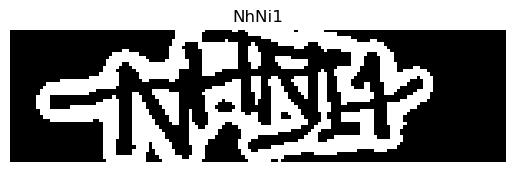

In [5]:

i = random.randint(0,49999)

# Display image from the dataset
rand_image = data.iloc[i]['binarized']  
rand_image = rand_image.squeeze() 


plt.imshow(rand_image, cmap="gray")
plt.title(f"{data.iloc[i]['filename']}")
plt.axis("off") 
plt.show()

In [6]:
# Define CHARSET and other related variables
CHARSET = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
CHAR2IDX = {char: idx for idx, char in enumerate(CHARSET)}
IDX2CHAR = {idx: char for char, idx in CHAR2IDX.items()}
NUM_CLASSES = len(CHARSET)
CAPTCHA_LEN = 5 

def encode_label(label):
    label = label[:CAPTCHA_LEN]  
    encoded = [CHAR2IDX.get(c, 0) for c in label]  # Unknown chars map to index 0
    return torch.tensor(encoded)

In [8]:
#define the dataset class to handle our images and labels
class CaptchaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data.iloc[idx]['binarized']
        label_str = self.data.iloc[idx]['filename']

        # Ensure the image has 3 channels (ResNet expects 3 channels)
        img = np.repeat(img, 3, axis=2)  # Convert to 3 channels if it's grayscale (repeating the grayscale channels)
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # Convert to CHW format: [3, H, W]

        label_tensor = encode_label(label_str)

        return img, label_tensor



In [9]:
# Split the dataset into training and validation sets (80% training, 20% validation)
train_df, val_df = train_test_split(data, test_size=0.2)

# Create datasets for training and validation
train_dataset = CaptchaDataset(train_df)
val_dataset = CaptchaDataset(val_df)

# Create DataLoader for both training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


In [10]:
class CaptchaResNet50(nn.Module):
    def __init__(self, num_chars=5, num_classes=62):  # num_classes = size of CHARSET
        super(CaptchaResNet50, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Modify the fully connected layer to match the number of classes (62 for each character)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes * num_chars)  # Output a flattened vector for 5 characters

        # LSTM to process the sequence of characters
        self.lstm = nn.LSTM(num_classes, 128, batch_first=True)  # Process each character
        self.fc_out = nn.Linear(128, num_classes)  # Output layer to predict each character's class

        self.num_chars = num_chars
        self.num_classes = num_classes

    def forward(self, x):
        # Use ResNet50 to extract features from the image
        x = self.resnet(x)  # [B, num_classes * num_chars]

        # Reshape to sequence form (B, num_chars, num_classes) for LSTM
        x = x.view(x.size(0), self.num_chars, self.num_classes)

        # Apply LSTM to sequence of characters
        x, _ = self.lstm(x)  # [B, num_chars, 128]

        # Output layer to predict class for each character
        x = self.fc_out(x)  # [B, num_chars, num_classes]

        return x  # Shape: [B, num_chars, num_classes]

# Example usage of the CaptchaResNet50 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the ResNet50-based model
model = CaptchaResNet50().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()



C:\Users\vyrus\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vyrus\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_best_model(model)
        elif val_loss < self.best_score - self.delta:
            self.best_score = val_loss
            self.counter = 0
            self.save_best_model(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_best_model(self, model):
        self.best_model_wts = model.state_dict()



In [ ]:
# Initialize model, optimizer, loss function, etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaResNet50().to(device)  # Change to the ResNet-based model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)


In [13]:

early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)

        # Compute the loss for each character
        loss = 0
        for i in range(labels.shape[1]):
            loss += criterion(outputs[:, i, :], labels[:, i])

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")

    for param_group in optimizer.param_groups:
        print(f"Learning rate: {param_group['lr']}")

    # Validation Phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_imgs, val_labels in val_loader:
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_imgs)

            val_loss_batch = 0
            for i in range(val_labels.shape[1]):
                val_loss_batch += criterion(val_outputs[:, i, :], val_labels[:, i])

            val_loss += val_loss_batch.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss:.4f}")

    # Check early stopping
    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    scheduler.step()  # Pass the validation loss to the scheduler



KeyboardInterrupt: 

In [ ]:
# Testing Phase
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0

predictions = []
labels_list = []
image_data = []

with torch.no_grad():
    for test_imgs, test_labels in val_loader:  # Iterate over the test loader
        test_imgs = test_imgs.to(device)
        test_labels = test_labels.to(device)

        test_outputs = model(test_imgs)

        loss = 0
        for i in range(test_labels.shape[1]):
            loss += criterion(test_outputs[:, i, :], test_labels[:, i])

        test_loss += loss.item()

        _, predicted = torch.max(test_outputs, 2)  # Get predicted class with the highest probability

        correct += (predicted == test_labels).sum().item()
        total += test_labels.size(0) * test_labels.size(1)

        # Store predictions, true labels, and images for evaluation
        for i in range(test_labels.shape[0]):
            for j in range(test_labels.shape[1]):
                predictions.append(predicted[i, j].item())
                labels_list.append(test_labels[i, j].item())
                image_data.append(test_imgs[i].cpu().numpy())

accuracy = (correct / total) * 100
test_loss_avg = test_loss / len(val_loader)

print(f"Test Loss: {test_loss_avg:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

precision = precision_score(labels_list, predictions, average='macro', labels=np.unique(predictions))
recall = recall_score(labels_list, predictions, average='macro', labels=np.unique(predictions))
f1 = f1_score(labels_list, predictions, average='macro', labels=np.unique(predictions))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
